<center>
<b>EC4.403: Robotics: Planning and Navigation</b> <br>
<b>Spring 2021</b> <br>
<b>Assignment-1 </b>
</center>

<div style="text-align: right"><b>Team:</b> Makkhi-2 (2018102023, 2018111003)</div>

In [23]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import os
import shutil

In [24]:
def addRectangle(image,x0,y0,height,width):
    '''Function to add rectangular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    image[y0:y0+height,x0:x0+width,:]=0
    return image

def addCircle(image,center_x, center_y,radius,colour=(0,0,0),thickness=-1):
    '''Function to add circular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    return cv2.circle(image,(center_x,center_y),radius,colour,thickness)

def addBorders(world,border_thickness=5):
    world[:,:border_thickness,:]=0 # Left border
    world[:border_thickness,:,:]=0 # Top border
    world[:,-border_thickness:,:]=0 # Right border
    world[-border_thickness:,:,:]=0 # Bottom border
    return world

def createWorld(height,width,start_point,goal_point):
    '''Function to make the world/occupancy grid.'''
    # Create an empty space of size heightxwidth
    world=np.uint8(np.full((height,width,3),255))
    
    # Add borders to our empty space
    world=addBorders(world)

    # Add rectangular obstacles to the world
    world=addRectangle(world,x0=25,y0=150,height=150,width=40)
    world=addRectangle(world,x0=250,y0=100,height=50,width=10)
    world=addRectangle(world,x0=250,y0=250,height=10,width=50)
    world=addRectangle(world,x0=100,y0=50,height=10,width=150)
    world=addRectangle(world,x0=50,y0=0,height=50,width=10)
    
    # Add circular obstacles to the world    
    world=addCircle(center_x=150,center_y=150,radius=50,image=world)
    
    # Mark start and end points on the world
    world=addCircle(image=world,center_x=start_point[0],center_y=start_point[1],\
                    radius=5,colour=(0,0,255),thickness=-1) #Draw a blue circle representing start
    world=addCircle(image=world,center_x=goal_point[0],center_y=goal_point[1],\
                    radius=5,colour=(0,255,0),thickness=-1) #Draw a green circle representing goal

    '''The empty spaces in the world correspond to the points where world[i][j]=255 and obstacles correspond to 
    places where world[i][j]=0'''    
    
    return world

def obstacleCount(world):
    return (world == [0, 0, 0]).all(axis = 2).sum()
def getFreeSpaces(world):
    return np.array(np.where((world == [255, 255, 255]).all(axis = 2))).T

def getObstacleSpaces(world):
    return np.array(np.where((world == [0, 0, 0]).all(axis = 2))).T

def getPath(path, steer_angle, b ,v_f):
    w, V = v_f * np.sin(steer_angle) / b, v_f * np.cos(steer_angle)
    path = path.copy().reshape(1, -1)
    for i in range(10): # step size
        path = np.append(path, np.array([[path[i, 0] + V * np.sin(path[i, 2]), path[i, 1] + V * np.cos(path[i, 2]), path[i, 2] + w]]), axis = 0)
    return path

# RRT - Non Holonomic Function Definition

In [25]:
def rrtNonHolonomic(world,b,v_f,max_steer_angle):
    tree = []
    tree.append([*robot_initial_point, 0, 0])
    tree=np.array(tree)
    tree = tree.reshape(1,-1)
    
    obstacle_count=obstacleCount(world)
    free_spaces = getFreeSpaces(world) # obstacle free_spaces space    
    free_spaces=free_spaces
    
    np_obs_points = getObstacleSpaces(world)
    world_copy = np.copy(world)
    frame_count = 1
    while True:
        rdm_idx = np.random.randint(len(free_spaces))
        x_k = free_spaces[rdm_idx] # row, col

        # finding the points with correct steering angle
        x_temp = x_k - tree[:, :2]
        x_temp = np.arctan2(x_temp[:, 0], x_temp[:, 1])
        x_temp = np.where(np.logical_and(x_temp <= max_steer_angle, -max_steer_angle <= x_temp)) # find the indices of all the points that satify the steering angle condition
        
        if len(x_temp[0]) == 0:
            continue
        else:
          # find the nearest node in the RRT tree
          x_temp = tree[x_temp[0], :]
          x_n = x_temp[distance.cdist([x_k], x_temp[:, :2]).argmin()]
          parent_index = np.where((tree == x_n).all(axis = 1))[0][0]

          # Get path
          x_temp = x_k - x_n[:2]
          steer_angle = np.arctan2(x_temp[0], x_temp[1]) # in radians
          np_path = getPath(x_n[:3], steer_angle,b,v_f)
        
          for i in range(len(np_path)):
              while 1: 
                if np_path[i, 2] < 0:np_path[i, 2] += 2*np.pi
                else: break
              while 1:
                if np_path[i, 2] > 2*np.pi: np_path[i, 2] -= 2*np.pi
                else: break
          np_path[:, :2] = np.round(np_path[:, :2])

          if distance.cdist(np_path[:, :2], np_obs_points).min() == 0:
              continue # collision occurred

          # no collision
          tree = np.append(tree, np.array([np_path[-1, 0], np_path[-1, 1], np_path[-1, 2], steer_angle, parent_index]).reshape(1, -1), axis = 0)
          for i in range(len(np_path)-1):
              world_copy = cv2.line(world_copy, tuple(np_path[i, :2].astype(np.int))[::-1], tuple(np_path[i+1, :2].astype(np.int))[::-1], (0, 0, 255), 1)

    #     plt.imshow(world_copy)
    #     plt.show()
          frame_count+= 1
        
          if np.linalg.norm(robot_final_point[:2] - np_path[-1, :2]) <= 10:
              break

    plt.imshow(world_copy)
    plt.title("Random Tree Evolution Graph")
    plt.show()

# Main

An image of our world.
Blue dot represents start node,
Green dot represents goal node,
Black regions represent obstacles
White regions represent empty spaces



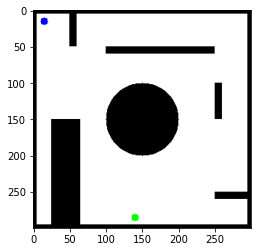

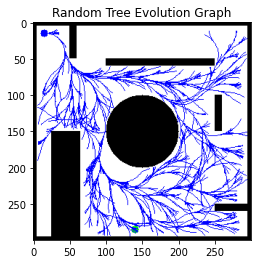

In [26]:
leng = 15
velo = 2 
max_steer_angle = 30*np.pi/180

robot_initial_point=(15,15,0)
robot_final_point=(140,285,0)
world=createWorld(300,300,robot_initial_point,robot_final_point)
# img_obstacles_mid = img_obstacles.copy()


print("An image of our world.\nBlue dot represents start node,\nGreen dot represents goal node,\n\
Black regions represent obstacles\nWhite regions represent empty spaces\n")

plt.imshow(world) # Visualize how are world looks like
plt.show()

rrtNonHolonomic(world,leng,velo,max_steer_angle)